In [1]:
import numpy as np
from matplotlib import pyplot as plt
import crowdmag as cm
import filterdata as filt

# Filter tests

Here are some of the options to filter data in Python: https://docs.scipy.org/doc/scipy/reference/signal.html

In [2]:
# Parameters
timestep = 70
filenameCM = 'crowdmag_3-22-22_iPhone12,1_2022-03-23 015401.csv'
#filenameCM = 'crowdmag_March 14 2022_iPhone12,1_2022-03-14 135556.csv'
#filenameCM = 'crowdmag_March 9 2022_iPhone12,1_2022-03-09 164809.csv'
pathCM = 'data/crowdmag/'
fieldtype = 'F'
startCM = 3
endCM = -1
bkps = 4
window_size = 10

# Read data
date,totalmag,magH,magX,magY,magZ = cm.ReadCSVCrowdMag(pathCM + filenameCM,
                                                       startCM = startCM, endCM = endCM,
                                                       dc_shift = True,bkps = bkps)

# Remove outliers
totalmag = filt.Outliers(totalmag)
magH = filt.Outliers(magH)

#time = date[3791:5025]
time = np.linspace(0,len(date),len(date))
mag = totalmag#[3791:5025]

C:\ProgramData\Anaconda3\lib\site-packages\ruptures\costs\costnormal.py:28: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


## Raw data

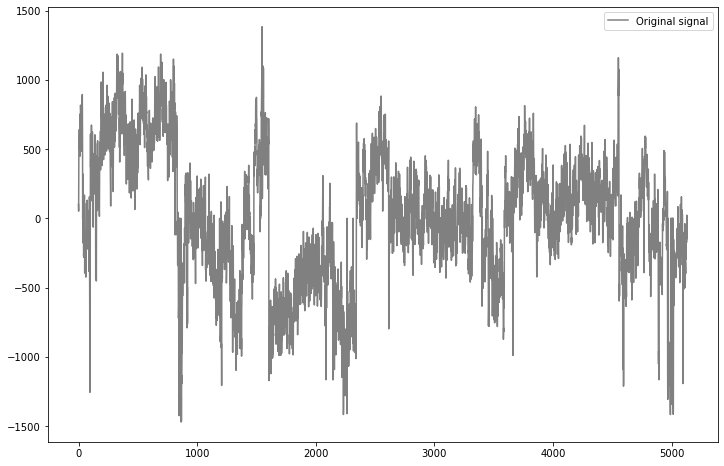

In [3]:
plt.figure(figsize=(12, 8))
plt.plot(time, mag, label='Original signal', color='grey')
plt.legend()
plt.show()

## Digital filter forward and backward to a signal (signal.filtfilt and signal.butter)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
 
    scipy.signal.butter(N, Wn, btype='low', analog=False, output='ba', fs=None)

    Butterworth digital and analog filter design.

    Design an Nth-order digital or analog Butterworth filter and return the filter coefficients.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html
    
    scipy.signal.filtfilt(b, a, x, axis=- 1, padtype='odd', padlen=None, method='pad', irlen=None)

    Apply a digital filter forward and backward to a signal.

    This function applies a linear digital filter twice, once forward and once backwards. The combined filter has zero phase and a filter order twice that of the original.

    The function provides options for handling the edges of the signal.

    The function sosfiltfilt (and filter design using output='sos') should be preferred over filtfilt for most filtering tasks, as second-order sections have fewer numerical problems"

In [4]:
from scipy import signal

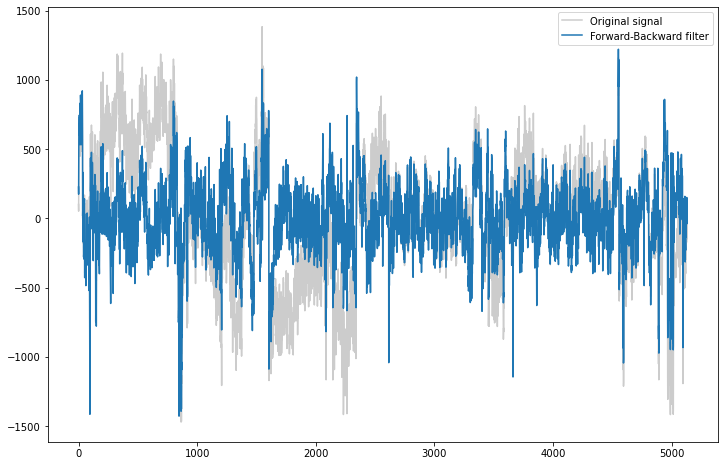

In [5]:
cutoff = 0.1
fs = 30
normal_cutoff = 0.1/(0.5 * fs)
order = 5
btype = 'highpass'
padlen = 10

nyq = 0.5 * fs
normal_cutoff = cutoff/nyq
b, a = signal.butter(order, normal_cutoff, btype, analog=False)
filtfilt_mag = signal.filtfilt(b, a, mag, padlen=padlen)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(time, mag, label='Original signal', color='grey', alpha=0.4)
plt.plot(time, filtfilt_mag, label='Forward-Backward filter')
plt.legend()
plt.show()

## Savitzky-Golay filter

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html#scipy.signal.savgol_filter
    
    scipy.signal.savgol_filter(x, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)

    Apply a Savitzky-Golay filter to an array.

    This is a 1-D filter. If x has dimension greater than 1, axis determines the axis along which the filter is applied.

In [6]:
from scipy import signal

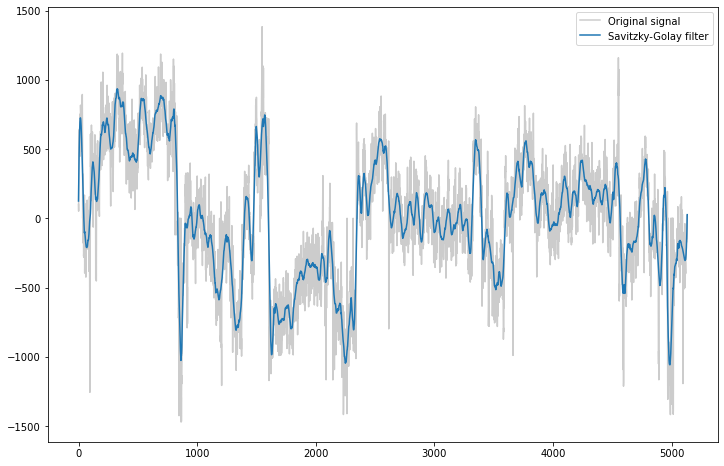

In [7]:
window_length = 99
polyorder = 5

savgol_mag = signal.savgol_filter(mag, window_length, polyorder)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(time, mag, label='Original signal', color='grey', alpha=0.4)
plt.plot(time, savgol_mag, label='Savitzky-Golay filter')
plt.legend()
plt.show()

## FFT 1: remove all high frequencies

Plot the power of the FFT of a signal and inverse FFT back to reconstruct
a signal.

This example demonstrate :func:`scipy.fftpack.fft`,
:func:`scipy.fftpack.fftfreq` and :func:`scipy.fftpack.ifft`. It
implements a basic filter that is very suboptimal, and should not be
used.

Source: https://scipy-lectures.org/intro/scipy/auto_examples/plot_fftpack.html

In [8]:
from scipy import fftpack

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


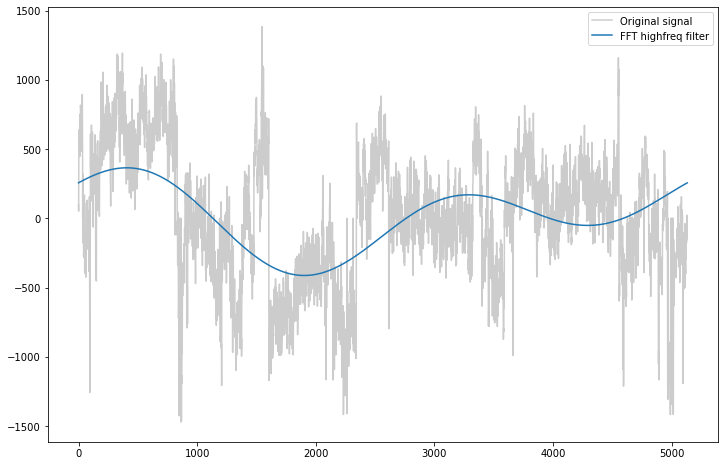

In [9]:
# FFT of the signal
sig_fft = fftpack.fft(mag)

# Power (sig_fft is of complex dtype)
power = np.abs(sig_fft)**2

# Corresponding frequencies
sample_freq = fftpack.fftfreq(mag.size, d = timestep)

# Find the peak frequency: only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

# We now remove all the high frequencies and transform back from frequencies to signal.
high_freq_fft = sig_fft.copy()
high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
ffthighfreq_mag = fftpack.ifft(high_freq_fft)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(time, mag, label='Original signal', color='grey', alpha=0.4)
plt.plot(time, ffthighfreq_mag, label='FFT highfreq filter')
plt.legend()
plt.show()

## FFT 2: bandpass filter

Source: https://stackoverflow.com/questions/19122157/fft-bandpass-filter-in-python

In [10]:
from scipy.fftpack import rfft, irfft, fftfreq

Lower limit of wavelength = 3.000e+14
Upper limit of wavelength = 1.000e+12


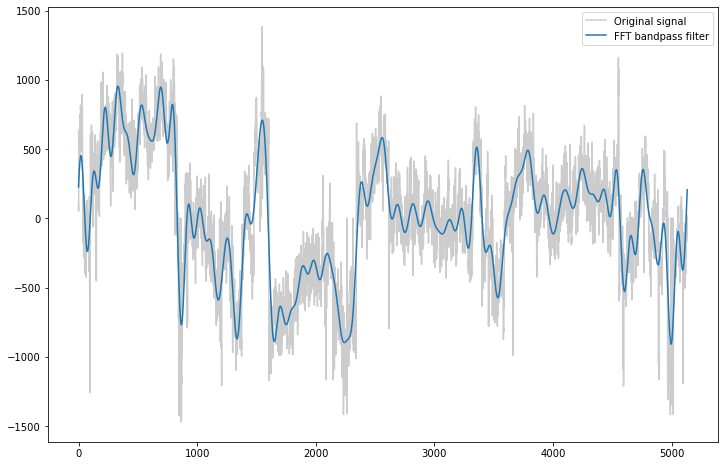

In [13]:
W = fftfreq(mag.size, d = timestep)
f_signal = rfft(mag)

low = 0.000001 #0.000001                       # Low frequencies
high = 0.0003 #0.0002                        # High frequencies

print("Lower limit of wavelength = {:.3e}".format(3e8/low))
print("Upper limit of wavelength = {:.3e}".format(3e8/high))

# If our original signal time was in seconds, this is now in Hz    
cut_f_signal = f_signal.copy()
cut_f_signal[(W>high)] = 0           # High frequencies
cut_f_signal[(W<low)] = 0            # Low frequencies

fftbandpass_mag = irfft(cut_f_signal)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(time, mag, label='Original signal', color='grey', alpha=0.4)
plt.plot(time, fftbandpass_mag, label='FFT bandpass filter')
plt.legend()
plt.show()

## Combining Digital filter forward and backward to a signal and FFT bandpass filter

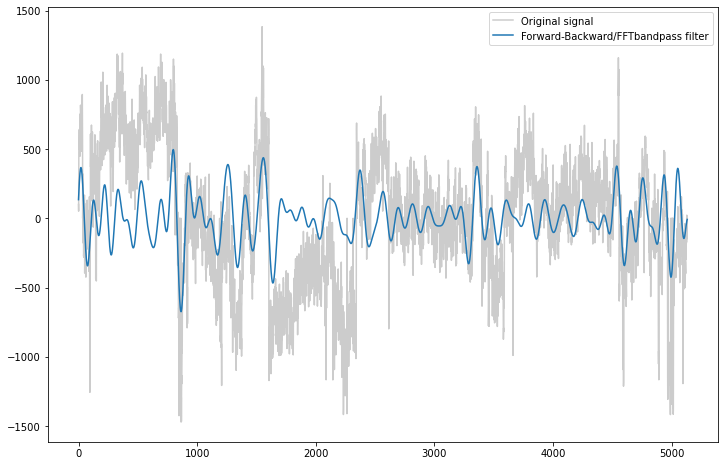

In [14]:
cutoff = 0.1
fs = 30
normal_cutoff = 0.1/(0.5 * fs)
order = 5
btype = 'highpass'
padlen = 10

nyq = 0.5 * fs
normal_cutoff = cutoff/nyq
b, a = signal.butter(order, normal_cutoff, btype, analog=False)
bandpassfiltfilt_mag = signal.filtfilt(b, a, fftbandpass_mag, padlen=padlen)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(time, mag, label='Original signal', color='grey', alpha=0.4)
plt.plot(time, bandpassfiltfilt_mag, label='Forward-Backward/FFTbandpass filter')
plt.legend()
plt.show()